In [1]:
# Standard library imports
import os
import warnings

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.patheffects as patheffects
import matplotlib.patches as mpatches
from matplotlib.patheffects import withStroke
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wradlib as wrl

In [2]:
# Configure warnings to ignore to maintain clean output
# warnings.filterwarnings("ignore")

# Setting a global environment variable for wradlib data
os.environ['WRADLIB_DATA'] = '/System/Volumes/Data/Users/michaeldavies/wradlib_data'

# Define the map projection
map_proj = ccrs.Mercator(central_longitude=-109.5) # Adjusted central_longitude to center the map

In [3]:
def plot_dem(ax, map_proj):
    # Load the DEM data file
    file_path = "/Users/michaeldavies/PycharmProjects/snowshadow/data/maybe.tif"
    data_file = wrl.util.get_wradlib_data_file(file_path)
    dataset = wrl.io.open_raster(data_file)

    # Reproject the raster dataset
    dataset = wrl.georef.reproject_raster_dataset(dataset, spacing=0.005, projection=map_proj)
    values, coords, proj = wrl.georef.extract_raster_dataset(dataset)

    # Create a custom colormap from the provided hex colors
    elevation_colormap = LinearSegmentedColormap.from_list("custom", ['#238443', '#D2B48C', '#8C6D31'], N=256)

    # Plotting the DEM using the custom colormap
    dem = ax.pcolormesh(
        coords[..., 0], coords[..., 1], values,
        cmap=elevation_colormap,
        norm=LogNorm(vmin=np.min(values[values > 0]), vmax=np.max(values)),
        transform=ccrs.PlateCarree()
    )

# Add a colorbar with improved readability for height
    color_bar = plt.colorbar(dem, ax=ax, orientation='horizontal', pad=0.05, shrink=0.5)
    color_bar.set_label('Elevation (m)')

# Set the color bar ticks manually
    color_bar.set_ticks([1241, 2000, 3000, 4000])  # Define the ticks to be at elevations you want to label

# Define custom tick labels without scientific notation
    color_bar.set_ticklabels(['1241', '2000', '3000', '4000'])

# Here's how you would do it without the 'k' and without scientific notation
    color_bar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{int(val)}'))

# Improve the appearance of the color bar
    color_bar.outline.set_edgecolor('black')
    color_bar.outline.set_linewidth(1)
    color_bar.ax.xaxis.set_tick_params(color='black', size=5)  # Make the ticks visible
    color_bar.ax.xaxis.label.set_size(10)  # Adjust the font size of the color bar label if necessary

# Return the coordinates, values, and color bar
    return coords, values, color_bar  # Return these for later use

In [4]:
def add_rivers_and_lakes(ax):
    # Add rivers
    rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',
                                          scale='10m', facecolor='none', edgecolor='blue')
    ax.add_feature(rivers, linewidth=1, zorder=2)

    # Add lakes
    lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes',
                                         scale='10m', facecolor='blue', edgecolor='blue')
    ax.add_feature(lakes, linewidth=1, zorder=2)

In [5]:
def add_cities(ax):
    # Define cities with coordinates
    uintah_basin_cities = [
        {"name": "Vernal", "lon": -109.5287, "lat": 40.4555},
        {"name": "Roosevelt", "lon": -109.9888, "lat": 40.2994},
        {"name": "Duchesne", "lon": -110.4029, "lat": 40.1633}
    ]

    colorado_cities = [
        {"name": "Dinosaur", "lon": -109.0099, "lat": 40.2417}
    ]

    other_utah_cities = [
        {"name": "Jensen", "lon": -109.3382, "lat": 40.3597},
        {"name": "Ouray", "lon": -109.7592, "lat": 40.0989},
        {"name": "Bonanza", "lon": -109.1902, "lat": 40.0359},
        {"name": "Price", "lon": -110.8107, "lat": 39.5994}
    ]

    # Define the color for each city group
    city_colors = {
        "uintah_basin": 'dodgerblue',
        "colorado": 'limegreen',
        "other_utah": 'tomato'
    }

    # Define text offset for the label position relative to the dot
    text_offset = 0.02  # Adjust as needed for appropriate spacing

    # Plot cities with a matching outline color and increase space between dot and text
    for city_group, label_color in zip(
        [uintah_basin_cities, colorado_cities, other_utah_cities],
        [city_colors["uintah_basin"], city_colors["colorado"], city_colors["other_utah"]]
    ):
        for city in city_group:
            # Dot for each city with an outline color matching the text color
            ax.scatter(city['lon'], city['lat'], color='black', s=40, linewidths=1,
                       edgecolors=label_color, transform=ccrs.PlateCarree())

            # Text with black outline effect and offset
            text_effects = [withStroke(linewidth=3, foreground="black")]
            ax.text(city['lon'] + text_offset, city['lat'] + text_offset, ' ' + city['name'], color=label_color, transform=ccrs.PlateCarree(),
                    fontsize=8, ha='left', va='center', path_effects=text_effects)

In [6]:
def add_geographical_features(ax):
    # Define features with coordinates and assign a star marker for each, with different colors
    features = [
        {"name": "King's Peak", "lon": -110.3729, "lat": 40.7763, "color": 'limegreen'},
        {"name": "Flaming Gorge Reservoir", "lon": -109.8791, "lat": 40.9190, "color": 'cyan'},
        {"name": "Book Cliffs", "lon": -109.5600, "lat": 39.1000, "color": 'dodgerblue'},
        {"name": "Dinosaur National Monument", "lon": -109.0060, "lat": 40.3697, "color": 'red'},
    ]

    # Define Green River label coordinates
    green_river_label_coords = (-110.01566331637217, 39.615752038874014)

    # Add features to the map using stars with black outlines
    for feature in features:
        ax.scatter(feature['lon'], feature['lat'], color=feature['color'], s=200, marker='*', edgecolors='black',
                   transform=ccrs.PlateCarree(), label=feature['name'], zorder=3)

# Add Green River label coordinates and make the text vertical
    green_river_label_coords = (-110.01566331637217, 39.615752038874014)
    text_effects = [withStroke(linewidth=2, foreground="black")]
    ax.text(green_river_label_coords[0], green_river_label_coords[1], "Green River",
            verticalalignment='center', horizontalalignment='center', color='turquoise',
            rotation='vertical', fontsize=9, transform=ccrs.PlateCarree(), path_effects=text_effects, zorder=4)


In [7]:
def add_legend(ax):
    # Create and add an updated legend to the axis
    legend_elements = [
        mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='None', markersize=5, label='Uintah Basin Cities'),
        mlines.Line2D([], [], color='limegreen', marker='o', linestyle='None', markersize=5, label='Colorado Cities'),
        mlines.Line2D([], [], color='tomato', marker='o', linestyle='None', markersize=5, label='Other Utah Cities'),
        mlines.Line2D([], [], color='limegreen', marker='*', linestyle='None', markersize=10, label="King's Peak"),
        mlines.Line2D([], [], color='cyan', marker='*', linestyle='None', markersize=10, label='Flaming Gorge Reservoir'),
        mlines.Line2D([], [], color='dodgerblue', marker='*', linestyle='None', markersize=10, label='Book Cliffs'),
        mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, label='Dinosaur National Monument')
    ]
    
    legend_obj = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., framealpha=0)

    # Set the face and edge color of the legend's background to none (transparent)
    frame = legend_obj.get_frame()
    frame.set_facecolor('none')
    frame.set_edgecolor('none')

    return legend_obj

In [8]:
def add_scale_bar(ax, scale_length_km, position=(0.05, 0.05), bar_height=0.005, bar_color='white', outline_color='black', outline_width=2):
    # Calculate the length of the scale bar in axes fraction
    extent = ax.get_extent(crs=ccrs.PlateCarree())
    map_width = extent[1] - extent[0]  # xmax - xmin in degrees longitude
    scale_length_degrees = (scale_length_km / 110.574)  # Rough conversion from km to degrees longitude at the equator
    scale_length_in_axes_fraction = scale_length_degrees / map_width
    
    # Draw the outline bar (background)
    ax.add_patch(Rectangle((position[0], position[1]), scale_length_in_axes_fraction, bar_height, 
                           transform=ax.transAxes, linewidth=outline_width, edgecolor=outline_color, facecolor='none', zorder=2))
    # Draw the scale bar (foreground)
    ax.add_patch(Rectangle((position[0], position[1]), scale_length_in_axes_fraction, bar_height, 
                           transform=ax.transAxes, facecolor=bar_color, zorder=3))

    # Add a text label above the scale bar
    text_position = (position[0] + scale_length_in_axes_fraction / 2, position[1] + bar_height)  # Position the text in the middle of the scale bar and slightly above it
    text_effects = [patheffects.withStroke(linewidth=3, foreground=outline_color)]  # Create a black outline effect for the text
    ax.text(text_position[0], text_position[1], f'{scale_length_km} km', transform=ax.transAxes, 
            horizontalalignment='center', verticalalignment='bottom', color=bar_color, 
            fontsize=10, fontweight='bold', path_effects=text_effects, zorder=4)  # Add the text label with the outline effect

In [9]:
def add_north_arrow(ax, arrow_length=0.05, arrow_location=(0.95, 0.9)):  # Adjusted arrow_location to move it down
    # Create the north arrow patch with a black outline, increase size by adjusting the arrowstyle parameters
    arrow = mpatches.FancyArrowPatch((arrow_location[0], arrow_location[1] - arrow_length * 2),  # Increased arrow_length
                                     arrow_location,
                                     transform=ax.transAxes, facecolor='white', edgecolor='black',
                                     arrowstyle='simple,tail_width=1,head_width=8,head_length=16',  # Increased dimensions
                                     lw=2, zorder=5)  # Increased linewidth

    # Add arrow to axes
    ax.add_patch(arrow)

    # Add 'N' label above the north arrow with a black outline, adjust font size and position
    ax.text(arrow_location[0], arrow_location[1] + 0.02,  # Adjusted position to align with the larger arrow
            'N', transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='bottom', color='white',
            fontsize=20,  # Increased font size
            zorder=5, path_effects=[withStroke(linewidth=2, foreground='black')])  # Increased outline thickness

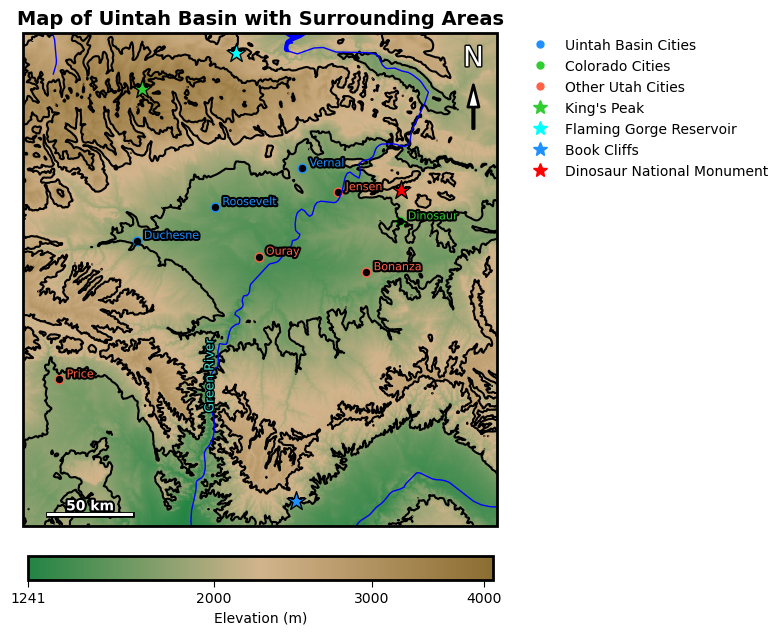

<Figure size 640x480 with 0 Axes>

In [10]:
# Create the figure and plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=map_proj)
ax.set_extent([-111.0, -108.5, 39.0, 41.0], crs=ccrs.PlateCarree())

# Call plot_dem() before ax.contour()
coords, values, color_bar = plot_dem(ax, map_proj)  # Store returned values

# Now you can use coords and values
ax.contour(coords[..., 0], coords[..., 1], values, levels=4, colors='black', transform=ccrs.PlateCarree())

# Set map title and add map features
ax.set_title("Map of Uintah Basin with Surrounding Areas", fontsize=14, fontweight='bold')
ax.coastlines(resolution='10m')
add_rivers_and_lakes(ax)
add_cities(ax)
add_geographical_features(ax)

# Add scale bar and north arrow
add_scale_bar(ax, 50, position=(0.05, 0.02)) # Add a scale bar of 50 km
add_north_arrow(ax)

# Adjust the appearance of the map
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(2)

# Ensure that color_bar and legend_obj are correctly defined earlier in your script
color_bar.outline.set_edgecolor('black')
color_bar.outline.set_linewidth(2)
legend_obj = add_legend(ax)
legend_obj.get_frame().set_edgecolor('black')
legend_obj.get_frame().set_linewidth(2)

# Save the figure
plt.savefig('full_map_plot.png', format='png', dpi=600, transparent=True)
plt.show()  # Display the plot
plt.clf()  # Clear the figure to remove any stray text or annotations

In [11]:
"""
A versatile mapping class designed for creating detailed geospatial visualizations with ease. The GenericMapPlotter class supports various cartographic projections and can dynamically integrate a wide range of geospatial data layers including DEMs, roads, cities, and weather data. It is designed to be flexible, allowing users to customize the map appearance and overlay various data types according to specific analytical needs. This class facilitates the creation of rich, informative maps for presentations, analysis, or publication.

Features:
- Flexible initialization with support for different Cartopy projections.
- Methods to load and plot Digital Elevation Models (DEMs) with customizable colormaps and normalization.
- Capability to add various geographic features such as cities and roads using data provided at runtime.
- Support for plotting gridded weather data as contour maps or heatmaps, complete with configurable color scales.
- Utility functions to enhance the map with navigational aids like scale bars and north arrows.
"""

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.patches import Rectangle, FancyArrowPatch
import matplotlib.patheffects as PathEffects
import cartopy.feature as cfeature

class GenericMapPlotter:
    def __init__(self, projection=None, fig_size=(12, 8)):
        """ Initialize the map plotter with a specific Cartopy projection and figure size. """
        self.projection = projection if projection else ccrs.PlateCarree()
        self.fig, self.ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': self.projection})

    def load_and_plot_dem(self, file_path, colormap, norm_range=None, spacing=0.005):
        """ Load DEM data from a file path and plot it using a specified colormap and normalization range. """
        dataset = wrl.io.open_raster(file_path)
        dataset = wrl.georef.reproject_raster_dataset(dataset, spacing=spacing, projection=self.projection)
        values, coords, proj = wrl.georef.extract_raster_dataset(dataset)
        norm = LogNorm(vmin=norm_range[0], vmax=norm_range[1]) if norm_range else None
        dem = self.ax.pcolormesh(coords[..., 0], coords[..., 1], values, cmap=colormap, norm=norm, transform=self.projection)
        return dem

    def add_features(self, features, feature_type='point', **kwargs):
        """ Add various geographical features such as cities or points of interest to the map. """
        if feature_type == 'point':
            for feature in features:
                self.ax.scatter(feature['lon'], feature['lat'], **kwargs)

    def add_roads(self, road_data, style_options=None):
        """ Add road data to the map with customizable style options. """
        if style_options is None:
            style_options = {'edgecolor': 'red', 'facecolor': 'none', 'linewidth': 2}
        roads = cfeature.ShapelyFeature(road_data, self.projection, **style_options)
        self.ax.add_feature(roads, **style_options)

    def plot_weather_data(self, lons, lats, data, plot_type='contourf', cmap='viridis', levels=None):
        """ Plot weather data as a contour map or heatmap. """
        if plot_type == 'contourf':
            weather = self.ax.contourf(lons, lats, data, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
        elif plot_type == 'heatmap':
            weather = self.ax.pcolormesh(lons, lats, data, cmap=cmap, transform=ccrs.PlateCarree())
        plt.colorbar(weather, orientation='vertical', pad=0.04, aspect=20, shrink=0.8, label='Weather Data')
        return weather

    def add_scale_bar(self, scale_length_km, position=(0.05, 0.05), bar_height=0.005, bar_color='white', outline_color='black', outline_width=2):
        """ Add a scale bar to the map indicating distance in kilometers. """
        extent = self.ax.get_extent(crs=ccrs.PlateCarree())
        map_width = extent[1] - extent[0]  # xmax - xmin in degrees longitude
        scale_length_degrees = (scale_length_km / 110.574)  # Rough conversion from km to degrees longitude at the equator
        scale_length_in_axes_fraction = scale_length_degrees / map_width
        self.ax.add_patch(Rectangle((position[0], position[1]), scale_length_in_axes_fraction, bar_height, 
                                    transform=self.ax.transAxes, linewidth=outline_width, edgecolor=outline_color, facecolor='none', zorder=2))
        self.ax.add_patch(Rectangle((position[0], position[1]), scale_length_in_axes_fraction, bar_height, 
                                    transform=self.ax.transAxes, facecolor=bar_color, zorder=3))
        text_position = (position[0] + scale_length_in_axes_fraction / 2, position[1] + bar_height)
        text_effects = [PathEffects.withStroke(linewidth=3, foreground=outline_color)]
        self.ax.text(text_position[0], text_position[1], f'{scale_length_km} km', transform=self.ax.transAxes, 
                     horizontalalignment='center', verticalalignment='bottom', color=bar_color, 
                     fontsize=10, fontweight='bold', path_effects=text_effects, zorder=4)

    def add_north_arrow(self, arrow_length=0.05, arrow_location=(0.95, 0.9)):
        """ Add a north arrow to the map for orientation. """
        arrow = FancyArrowPatch((arrow_location[0], arrow_location[1] - arrow_length * 2), arrow_location,
                                transform=self.ax.transAxes, facecolor='white', edgecolor='black',
                                arrowstyle='simple,tail_width=1,head_width=8,head_length=16', lw=2, zorder=5)
        self.ax.add_patch(arrow)
        self.ax.text(arrow_location[0], arrow_location[1] + 0.02, 'N', transform=self.ax.transAxes,
                     horizontalalignment='center', verticalalignment='bottom', color='white',
                     fontsize=20, path_effects=[PathEffects.withStroke(linewidth=2, foreground='black')])

    def finalize_map(self, title, extent, coastline_resolution='10m'):
        """ Finalize the map by setting its extent, title, and optionally adding coastlines. """
        self.ax.set_extent(extent, crs=self.projection)
        self.ax.set_title(title, fontsize=14, fontweight='bold')
        if coastline_resolution:
            self.ax.coastlines(resolution=coastline_resolution)
        plt.show()

# Example usage can be provided based on the setup of your data and local environment.


# Example Usage:
# plotter = GenericMapPlotter()
# dem_colormap = LinearSegmentedColormap.from_list("elev", ['#000000', '#FFFFFF'], N=256)
# plotter.load_and_plot_dem('path/to/dem/file.tif', dem_colormap, norm_range=(100, 2000))
# cities = [{'name': 'City1', 'lon': -120.0, 'lat': 35.0}, {'name': 'City2', 'lon': -121.0, 'lat': 36.0}]
# plotter.add_features(cities, feature_type='point', color='red', s=10)
# plotter.finalize_map("Sample Map", [-122, -118, 34, 37])
